In [1]:
import robot_plotter as rp
import models_functions as mf
import traj
import numpy as np
import matplotlib.pyplot as plt
import robot_sim as sim
import sim_helper_funcs as hfunc
import save_load_data as sldat

In [5]:
# Now, load the data

robcol = sldat.load_object('test')

pos1 = robcol.robotlist[0].pos
pos2 = robcol.robotlist[1].pos
pos3 = robcol.robotlist[2].pos
x_log1 = robcol.robotlist[0].x_log
x_log2 = robcol.robotlist[1].x_log
x_log3 = robcol.robotlist[2].x_log
P_log1 = robcol.robotlist[0].P_log
P_log2 = robcol.robotlist[1].P_log
P_log3 = robcol.robotlist[2].P_log

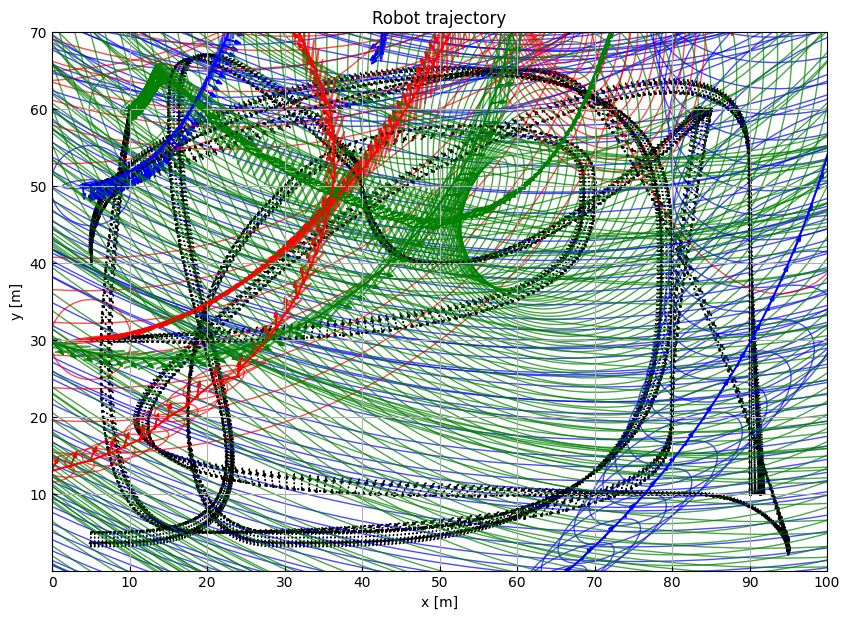

In [6]:
# And plot:
s_idx = 0

# Plot ground truth
fig, ax = rp.setup_plot()
rp.plot_position(ax, pos1[:,::100], color='black', marker=None, linestyle=':', label='Robot 1 reference')
rp.plot_position(ax, pos2[:,::100], color='black', marker=None, linestyle=':', label='Robot 2 reference')
rp.plot_position(ax, pos3[:,::100], color='black', marker=None, linestyle=':', label='Robot 3 reference')

# Plot states of robots:
rp.plot_position2(ax, x_log1[:,::100,s_idx], P_log1[:,:,::100,s_idx], color='blue', marker=None, label='Robot 1 trajectory')
rp.plot_position2(ax, x_log2[:,::100,s_idx], P_log2[:,:,::100,s_idx], color='red', marker=None, label='Robot 2 trajectory')
rp.plot_position2(ax, x_log3[:,::100,s_idx], P_log3[:,:,::100,s_idx], color='green', marker=None, label='Robot 3 trajectory')

